<a href="https://colab.research.google.com/github/ash07-6/image-detection-and-clothing-recommendation-using-yolo/blob/main/Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Hi! Step 1: Install dependencies and import libraries
!pip install ultralytics opencv-python matplotlib mediapipe

# Import libraries
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Hi! Step 3: Set dataset location and YAML config
dataset_path = '/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8'
data_yaml_path = '/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/data.yaml'

print("✅ Step 3 complete: Dataset and YAML paths set!")

✅ Step 3 complete: Dataset and YAML paths set!


In [ ]:
# Hi! Step 4: Ensure validation path exists in YAML
with open(data_yaml_path, 'r') as f:
    lines = f.readlines()

for i, line in enumerate(lines):
    if line.strip().startswith('val:'):
        lines[i] = f"val: {dataset_path}/train/images\n"  # change if needed

with open(data_yaml_path, 'w') as f:
    f.writelines(lines)

print("✅ Step 4 complete: data.yaml updated to fix validation path!")


✅ Step 4 complete: data.yaml updated to fix validation path!


In [ ]:
# Hi! Step 5: Train YOLOv8 on your custom dataset (skip if already have best.pt)
model = YOLO('yolov8n.pt')  # lightweight YOLOv8 model for Colab

model.train(
    data=data_yaml_path,
    epochs=35,
    imgsz=640,
    batch=8,
    name='clothing_custom',
    workers=2,

)

print("✅ Step 5 complete: YOLOv8 training started/completed!")

Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=35, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=clothing_custom, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask

In [ ]:
# -------------------------------
# Step 1: Install dependencies
# -------------------------------
!pip install ultralytics opencv-python matplotlib mediapipe

# -------------------------------
# Step 2: Imports
# -------------------------------
from ultralytics import YOLO
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt
from google.colab import files
import os

# -------------------------------
# Step 3: Upload images
# -------------------------------
uploaded = files.upload()  # Choose one or more images

# -------------------------------
# Step 4: Load trained YOLO model
# -------------------------------
model = YOLO("/content/runs/detect/clothing_custom2/weights/best.pt")

# -------------------------------
# Step 5: Define clothing classes
# -------------------------------
upper_body_classes = ['Jacket', 'Shirt', 'Sweater', 'Top', 'Tshirt']
lower_body_classes = ['Pants', 'Shorts', 'Skirt']

girls_upper_classes = ['Top', 'Sweater', 'Tshirt']
boys_upper_classes = ['Shirt', 'Jacket', 'Sweater', 'Tshirt']

# -------------------------------
# Step 6: Detect person type (Boy/Girl)
# -------------------------------
def detect_person_type(upper_class):
    if upper_class in girls_upper_classes:
        return 'Girl'
    elif upper_class in boys_upper_classes:
        return 'Boy'
    else:
        return 'Unknown'

# -------------------------------
# Step 7: Estimate body size using MediaPipe Pose
# -------------------------------
def estimate_size(image_path):
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=True)

    image = cv2.imread(image_path)
    if image is None:
        return "Unknown"

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape
    results = pose.process(image_rgb)

    if not results.pose_landmarks:
        return "Unknown"

    lm = results.pose_landmarks.landmark
    try:
        head_y = lm[0].y
        left_ankle_y = lm[27].y
        right_ankle_y = lm[28].y
        bottom_y = max(left_ankle_y, right_ankle_y)
        left_shoulder_x = lm[11].x
        right_shoulder_x = lm[12].x

        pixel_height = (bottom_y - head_y) * h
        relative_height = pixel_height / h
        shoulder_width = abs(right_shoulder_x - left_shoulder_x) * w
        relative_width = shoulder_width / w

        score = 0.6 * relative_height + 0.4 * relative_width

        if score < 0.5:
            return 'Small'
        elif score < 0.7:
            return 'Medium'
        else:
            return 'Large'
    except:
        return "Unknown"

# -------------------------------
# Step 8: Create output folder
# -------------------------------
save_dir = "/content/results"
os.makedirs(save_dir, exist_ok=True)

# -------------------------------
# Step 9: Run detections + draw results
# -------------------------------
for image_path in uploaded.keys():
    img = cv2.imread(image_path)
    results = model.predict(image_path, imgsz=640, conf=0.5)
    size_label = estimate_size(image_path)

    upper_class = 'Unknown'
    lower_class = 'Unknown'

    if results and len(results) > 0:
        boxes = results[0].boxes
        if boxes is not None and len(boxes) > 0:
            for i in range(len(boxes)):
                cls_id = int(boxes.cls[i])
                class_name = model.names[cls_id].capitalize()
                conf = float(boxes.conf[i]) * 100  # Confidence percentage

                x1, y1, x2, y2 = map(int, boxes.xyxy[i])

                if class_name in upper_body_classes:
                    upper_class = class_name
                elif class_name in lower_body_classes:
                    lower_class = class_name

                person_type = detect_person_type(upper_class)
                label = f"{person_type} | {upper_class}/{lower_class} | Size: {size_label} | {conf:.1f}%"

                # Draw bounding box + label
                cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
                cv2.putText(img, label, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)

    # Save annotated image
    save_path = os.path.join(save_dir, f"annotated_{os.path.basename(image_path)}")
    cv2.imwrite(save_path, img)

    # Display the annotated image
    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"{image_path} - Saved ✅")
    plt.show()

    # Print summary
    print(f"Image: {image_path}")
    print(f"  Size: {size_label}")
    print(f"  Upper Body: {upper_class}")
    print(f"  Lower Body: {lower_class}")
    print(f"  Person Type: {detect_person_type(upper_class)}")
    print(f"  ✅ Saved annotated image at: {save_path}")
    print("------")

print("\n✅ All annotated images saved in:", save_dir)


Saving ad1.jpg to ad1.jpg


FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/detect/clothing_custom2/weights/best.pt'

Saving ju.jpg to ju.jpg

image 1/1 /content/ju.jpg: 640x320 1 Pants, 1 Tshirt, 64.8ms
Speed: 2.7ms preprocess, 64.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 320)
Person 1 in ju.jpg:
  Size: Unknown
  Upper Body: None
  Lower Body: Pants
  Person Type: Unknown
------
Person 2 in ju.jpg:
  Size: Small
  Upper Body: Tshirt
  Lower Body: None
  Person Type: Girl
------
Saved annotated image to /content/drive/MyDrive/Annotated_Images/annotated_ju.jpg


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


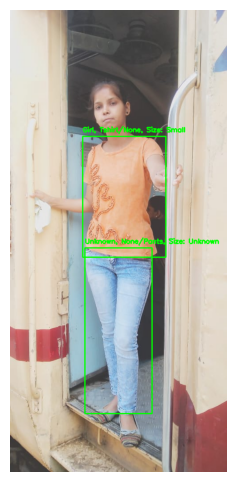

In [ ]:
# -------------------------------
# Step 1: Upload Images
# -------------------------------
from google.colab import files
uploaded = files.upload()  # select multiple images if needed

# -------------------------------
# Step 2: Load YOLOv8 Model
# -------------------------------
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import mediapipe as mp
import os

# Select the model you want to use
# Options: best.pt, last.pt, yolov8n.pt
model_path = "/content/runs/detect/clothing_custom/weights/last.pt"
model = YOLO(model_path)

# Initialize MediaPipe Pose globally
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

# -------------------------------
# Step 3: Define Classes (No accessories)
# -------------------------------
upper_body_classes = ['Jacket', 'Shirt', 'Sweater', 'Top', 'Tshirt']
lower_body_classes = ['Pants', 'Shorts', 'Skirt']

# Gender detection based on upper body
girls_upper_classes = ['Top', 'Tshirt']  # female-oriented
boys_upper_classes = ['Shirt', 'Jacket', 'Sweater', 'Tshirt']  # male-oriented

def detect_person_type(upper_class):
    if upper_class in girls_upper_classes:
        return 'Girl'
    elif upper_class in boys_upper_classes:
        return 'Boy'
    else:
        return 'Unknown'

# -------------------------------
# Step 4: Size Estimation Function
# -------------------------------
def estimate_size_person(cropped_img):
    if cropped_img is None or cropped_img.size == 0:
        return "Unknown"

    image_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    h, w, _ = cropped_img.shape
    results = pose.process(image_rgb)

    if not results.pose_landmarks:
        return "Unknown"

    lm = results.pose_landmarks.landmark
    try:
        head_y = lm[0].y
        left_ankle_y = lm[27].y
        right_ankle_y = lm[28].y
        bottom_y = max(left_ankle_y, right_ankle_y)
        left_shoulder_x = lm[11].x
        right_shoulder_x = lm[12].x

        pixel_height = (bottom_y - head_y) * h
        relative_height = pixel_height / h
        shoulder_width = abs(right_shoulder_x - left_shoulder_x) * w
        relative_width = shoulder_width / w
        score = 0.6 * relative_height + 0.4 * relative_width

        if score < 0.5:
            return 'Small'
        elif score < 0.7:
            return 'Medium'
        else:
            return 'Large'
    except:
        return "Unknown"

# -------------------------------
# Step 5: Detect and Annotate Images
# -------------------------------
# Path to save annotated images
drive_save_path = "/content/drive/MyDrive/Annotated_Images"
os.makedirs(drive_save_path, exist_ok=True)

for image_path in uploaded.keys():
    img = cv2.imread(image_path)
    results = model.predict(image_path, imgsz=640)
    annotated_img = img.copy()

    for i, box in enumerate(results[0].boxes):
        cls_id = int(box.cls)
        class_name = model.names[cls_id].capitalize()
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(img.shape[1], x2), min(img.shape[0], y2)
        cropped_person = img[y1:y2, x1:x2]
        if cropped_person.size == 0:
            continue

        # Determine upper/lower clothing
        upper_class = class_name if class_name in upper_body_classes else None
        lower_class = class_name if class_name in lower_body_classes else None

        # Size and person type
        size_label = estimate_size_person(cropped_person)
        person_type = detect_person_type(upper_class)

        # Draw boxes and label
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0,255,0), 2)
        label = f"{person_type}, {upper_class}/{lower_class}, Size: {size_label}"
        cv2.putText(annotated_img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

        # Print details
        print(f"Person {i+1} in {image_path}:")
        print(f"  Size: {size_label}")
        print(f"  Upper Body: {upper_class}")
        print(f"  Lower Body: {lower_class}")
        print(f"  Person Type: {person_type}")
        print("------")

    # Save annotated image to Drive
    save_file = os.path.join(drive_save_path, f"annotated_{image_path}")
    cv2.imwrite(save_file, annotated_img)
    print(f"Saved annotated image to {save_file}")

    # Display annotated image
    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()  # select multiple images if needed


Saving ad1.jpg to ad1 (2).jpg


In [ ]:
from google.colab import files
uploaded = files.upload()  # select multiple images if needed


Saving h1.jpg to h1.jpg


In [ ]:
import cv2

for image_path in uploaded.keys():
    img = cv2.imread(image_path)  # reads uploaded image
    # Now you can pass `img` to YOLO or crop boxes


In [ ]:
def detect_and_crop(img, model):
    """
    img: cv2 image
    model: YOLOv8 model
    returns: list of cropped clothing images and their labels
    """
    results = model.predict(img, imgsz=640)
    cropped_items = []

    for box in results[0].boxes:
        cls_id = int(box.cls)
        class_name = model.names[cls_id].capitalize()
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(img.shape[1], x2), min(img.shape[0], y2)
        cropped_img = img[y1:y2, x1:x2]
        if cropped_img.size > 0:
            cropped_items.append((cropped_img, class_name))
    return cropped_items



0: 640x512 2 Jackets, 1 Pants, 1 Shirt, 65.6ms
Speed: 5.6ms preprocess, 65.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)
Cropped item 1: Pants


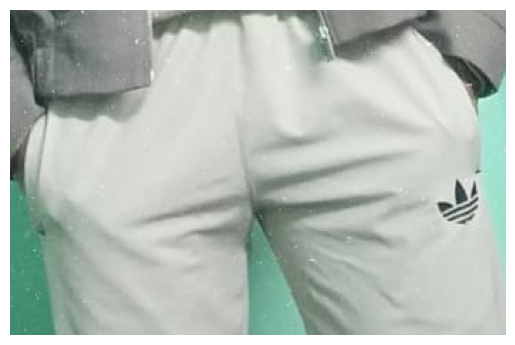

Cropped item 2: Jacket


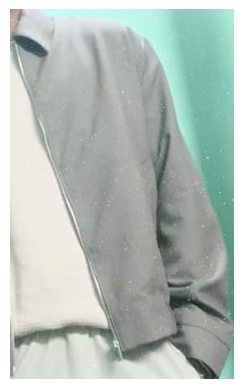

Cropped item 3: Jacket


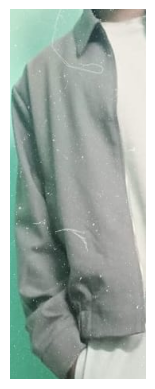

Cropped item 4: Shirt


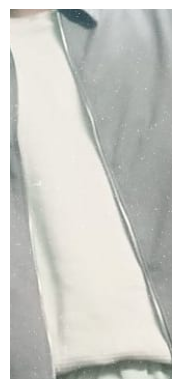

In [ ]:
for image_path in uploaded.keys():
    img = cv2.imread(image_path)
    crops = detect_and_crop(img, model)
    for i, (crop, label) in enumerate(crops):
        print(f"Cropped item {i+1}: {label}")
        # Optional: show image
        from matplotlib import pyplot as plt
        plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()  # select multiple images if needed


Saving asu.jpg to asu.jpg


In [ ]:
import cv2
from ultralytics import YOLO
import mediapipe as mp
from matplotlib import pyplot as plt
import os

# Load YOLO model (use your previous trained weights)
model_path = "/content/runs/detect/clothing_custom/weights/last.pt"
model = YOLO(model_path)

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

# Clothing classes
upper_body_classes = ['Jacket', 'Shirt', 'Sweater', 'Top', 'Tshirt']
lower_body_classes = ['Pants', 'Shorts', 'Skirt']

girls_upper_classes = ['Top', 'Tshirt']  # female-oriented
boys_upper_classes = ['Shirt', 'Jacket', 'Sweater', 'Tshirt']  # male-oriented

def detect_person_type(upper_class):
    if upper_class in girls_upper_classes:
        return 'Girl'
    elif upper_class in boys_upper_classes:
        return 'Boy'
    else:
        return 'Unknown'

def estimate_size_person(cropped_img):
    if cropped_img is None or cropped_img.size == 0:
        return "Unknown"
    image_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    h, w, _ = cropped_img.shape
    results = pose.process(image_rgb)
    if not results.pose_landmarks:
        return "Unknown"
    lm = results.pose_landmarks.landmark
    try:
        head_y = lm[0].y
        left_ankle_y = lm[27].y
        right_ankle_y = lm[28].y
        bottom_y = max(left_ankle_y, right_ankle_y)
        left_shoulder_x = lm[11].x
        right_shoulder_x = lm[12].x

        pixel_height = (bottom_y - head_y) * h
        relative_height = pixel_height / h
        shoulder_width = abs(right_shoulder_x - left_shoulder_x) * w
        relative_width = shoulder_width / w
        score = 0.6 * relative_height + 0.4 * relative_width

        if score < 0.5:
            return 'Small'
        elif score < 0.7:
            return 'Medium'
        else:
            return 'Large'
    except:
        return "Unknown"

# -------------------------------
# Function to process a single image
# -------------------------------
def process_single_image(img_path, save_annotated=True, display=True, save_folder=None):
    """
    img_path: path to the new image
    Returns: list of dicts for each detected person/clothing
    """
    img = cv2.imread(img_path)
    if img is None:
        print("Image not found or cannot be read.")
        return

    results = model.predict(img, imgsz=640)
    annotated_img = img.copy()
    output_info = []

    for i, box in enumerate(results[0].boxes):
        cls_id = int(box.cls)
        class_name = model.names[cls_id].capitalize()
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(img.shape[1], x2), min(img.shape[0], y2)
        cropped_img = img[y1:y2, x1:x2]
        if cropped_img.size == 0:
            continue

        upper_class = class_name if class_name in upper_body_classes else None
        lower_class = class_name if class_name in lower_body_classes else None
        size_label = estimate_size_person(cropped_img)
        person_type = detect_person_type(upper_class)

        # Store all info in dictionary
        output_info.append({
            "upper_class": upper_class,
            "lower_class": lower_class,
            "size": size_label,
            "person_type": person_type,
            "box": (x1, y1, x2, y2),
            "cropped_img": cropped_img
        })

        # Draw annotated boxes
        label = f"{person_type}, {upper_class}/{lower_class}, Size: {size_label}"
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(annotated_img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

    # Save annotated image
    if save_annotated:
        if save_folder is None:
            save_folder = "/content/Annotated_Images"
        os.makedirs(save_folder, exist_ok=True)
        save_path = os.path.join(save_folder, f"annotated_{os.path.basename(img_path)}")
        cv2.imwrite(save_path, annotated_img)
        print(f"Annotated image saved to {save_path}")

    # Display annotated image
    if display:
        plt.figure(figsize=(10,6))
        plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    return output_info


In [ ]:
from google.colab import files
uploaded = files.upload()  # select multiple images if needed


Saving IMG_20211106_092139.jpg to IMG_20211106_092139 (1).jpg



0: 640x640 1 Sweater, 8.1ms
Speed: 3.5ms preprocess, 8.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)
Annotated image saved to /content/Annotated_Images/annotated_IMG_20211106_092139.jpg


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


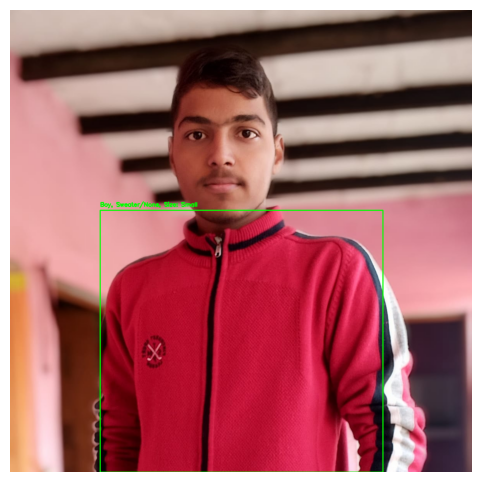

Person 1: Upper: Sweater, Lower: None, Size: Small, Type: Boy


In [ ]:
# Pass a new image each time
results = process_single_image("/content/IMG_20211106_092139.jpg")

# Print all detected results
for i, person in enumerate(results):
    print(f"Person {i+1}: Upper: {person['upper_class']}, Lower: {person['lower_class']}, "
          f"Size: {person['size']}, Type: {person['person_type']}")


In [ ]:
from google.colab import files
uploaded = files.upload()  # select multiple images if needed


Saving l1.jpg to l1.jpg



0: 640x320 1 Pants, 1 Sweater, 9.4ms
Speed: 4.2ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)
Annotated image saved to /content/Annotated_Images/annotated_l1.jpg


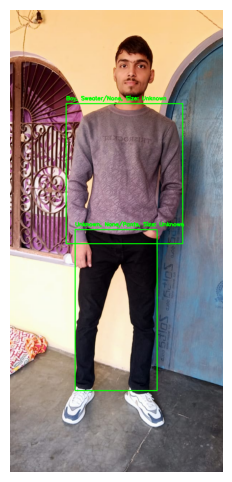

Person 1: Upper: Sweater, Lower: None, Size: Unknown, Type: Boy
Person 2: Upper: None, Lower: Pants, Size: Unknown, Type: Unknown


In [ ]:
# Pass a new image each time
results = process_single_image("/content/l1.jpg")

# Print all detected results
for i, person in enumerate(results):
    print(f"Person {i+1}: Upper: {person['upper_class']}, Lower: {person['lower_class']}, "
          f"Size: {person['size']}, Type: {person['person_type']}")


In [ ]:
from google.colab import files
uploaded = files.upload()  # select multiple images if needed


Saving akash.jpg to akash.jpg



0: 640x640 1 Pants, 1 Shirt, 9.6ms
Speed: 3.9ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Annotated image saved to /content/Annotated_Images/annotated_akash.jpg


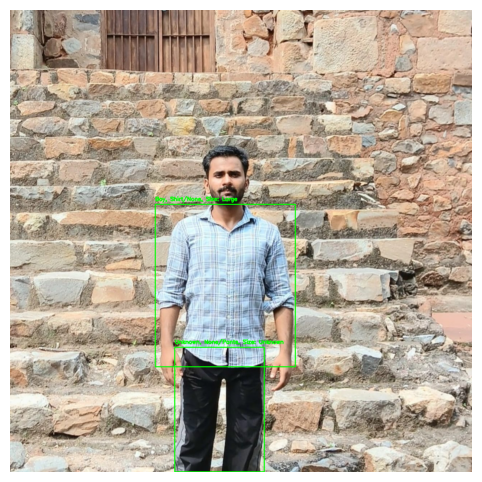

Person 1: Upper: Shirt, Lower: None, Size: Large, Type: Boy
Person 2: Upper: None, Lower: Pants, Size: Unknown, Type: Unknown


In [ ]:
# Pass a new image each time
results = process_single_image("/content/akash.jpg")

# Print all detected results
for i, person in enumerate(results):
    print(f"Person {i+1}: Upper: {person['upper_class']}, Lower: {person['lower_class']}, "
          f"Size: {person['size']}, Type: {person['person_type']}")

In [ ]:
# Make a folder in your Drive to store YOLO weights
!mkdir -p /content/drive/MyDrive/YOLO_weights/

# Copy best.pt to Drive
!cp /content/runs/detect/clothing_custom/weights/best.pt /content/drive/MyDrive/YOLO_weights/best.pt


cp: cannot stat '/content/runs/detect/clothing_custom/weights/best.pt': No such file or directory


In [ ]:
# =============================================
# 🧠 Colab Initialization Block (Ashwani Project)
# =============================================

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Install required packages (run only if not installed)
!pip install ultralytics opencv-python mediapipe matplotlib --quiet

# Step 3: Import all dependencies
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import mediapipe as mp
import os

# Step 4: Define model path (already saved in Drive)
model_path = "/content/drive/MyDrive/YOLO_weights/best.pt"

# Step 5: Load model
model = YOLO(model_path)
print("✅ Model loaded successfully from:", model_path)

# Step 6: Prepare output folder (for annotated results)
drive_save_path = "/content/drive/MyDrive/Annotated_Images"
os.makedirs(drive_save_path, exist_ok=True)
print("📁 Output folder ready at:", drive_save_path)

# Step 7: Initialize MediaPipe Pose once
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

print("🚀 All systems ready — you can now upload and test images!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https:

Saving tri.jpg to tri.jpg

🔍 Processing image: tri.jpg

image 1/1 /content/tri.jpg: 640x416 4 Shirts, 67.8ms
Speed: 7.9ms preprocess, 67.8ms inference, 343.5ms postprocess per image at shape (1, 3, 640, 416)


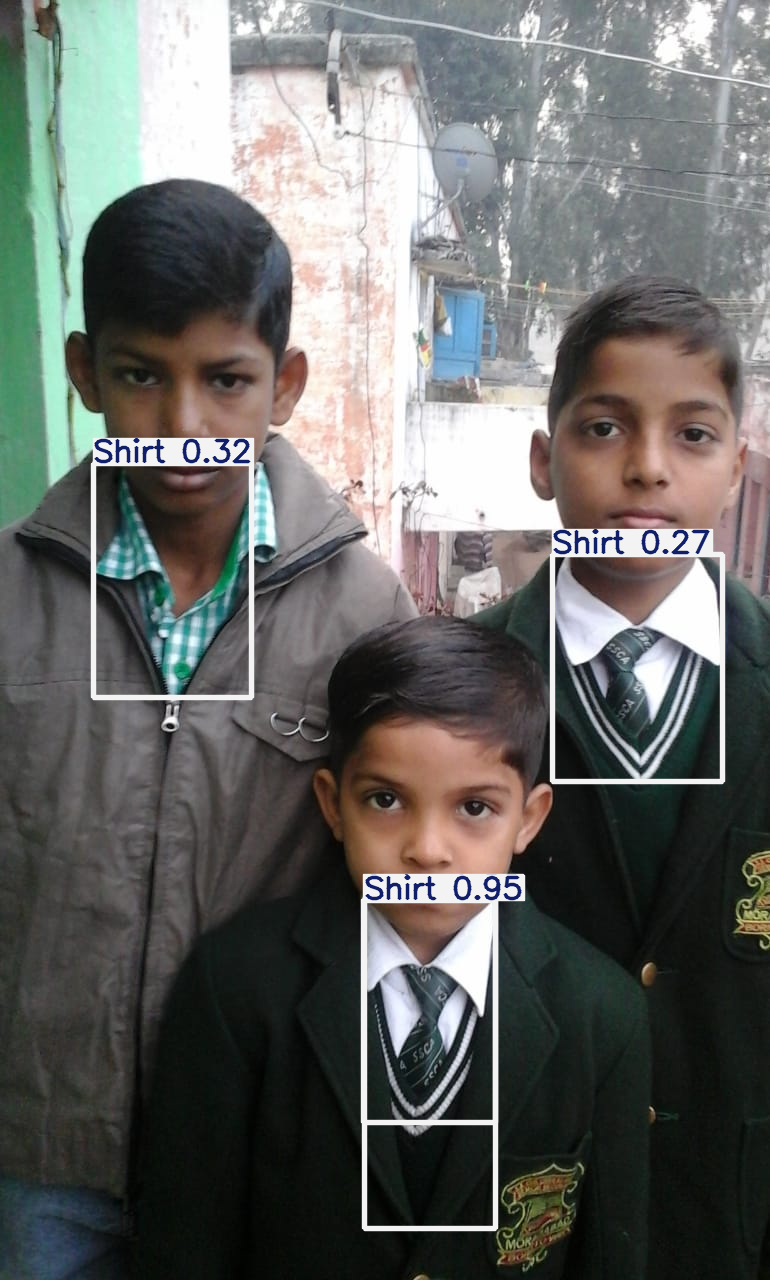

In [ ]:
from google.colab import files

# Upload image(s)
uploaded = files.upload()

# Run detection on each uploaded image
for image_path in uploaded.keys():
    print(f"\n🔍 Processing image: {image_path}")
    results = model.predict(source=image_path, imgsz=640)
    results[0].show()


In [ ]:
from google.colab import files
uploaded = files.upload()  # select multiple images if needed


Saving ad1.jpg to ad1.jpg


In [ ]:
# Pass a new image each time
results = process_single_image("/content/ad1.jpg")

# Print all detected results
for i, person in enumerate(results):
    print(f"Person {i+1}: Upper: {person['upper_class']}, Lower: {person['lower_class']}, "
          f"Size: {person['size']}, Type: {person['person_type']}")

NameError: name 'process_single_image' is not defined

In [ ]:
def process_single_image(image_path):
    import cv2
    import os
    from matplotlib import pyplot as plt

    if not os.path.exists(image_path):
        print("❌ Image not found or cannot be read.")
        return None

    img = cv2.imread(image_path)
    if img is None:
        print("❌ Image not found or cannot be read.")
        return None

    # Run YOLO prediction
    results = model.predict(image_path, imgsz=640)
    annotated_img = img.copy()

    for i, box in enumerate(results[0].boxes):
        cls_id = int(box.cls)
        class_name = model.names[cls_id].capitalize()
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(img.shape[1], x2), min(img.shape[0], y2)
        cropped_person = img[y1:y2, x1:x2]
        if cropped_person.size == 0:
            continue

        # Determine upper/lower body classes
        upper_body_classes = ['Jacket', 'Shirt', 'Sweater', 'Top', 'Tshirt']
        lower_body_classes = ['Pants', 'Shorts', 'Skirt']
        girls_upper_classes = ['Top', 'Tshirt', 'Sweater']
        boys_upper_classes = ['Shirt', 'Jacket']

        upper_class = class_name if class_name in upper_body_classes else None
        lower_class = class_name if class_name in lower_body_classes else None

        # Estimate size
        image_rgb = cv2.cvtColor(cropped_person, cv2.COLOR_BGR2RGB)
        h, w, _ = cropped_person.shape
        results_pose = pose.process(image_rgb)
        if not results_pose.pose_landmarks:
            size_label = "Unknown"
        else:
            lm = results_pose.pose_landmarks.landmark
            try:
                head_y = lm[0].y
                left_ankle_y = lm[27].y
                right_ankle_y = lm[28].y
                bottom_y = max(left_ankle_y, right_ankle_y)
                left_shoulder_x = lm[11].x
                right_shoulder_x = lm[12].x
                pixel_height = (bottom_y - head_y) * h
                relative_height = pixel_height / h
                shoulder_width = abs(right_shoulder_x - left_shoulder_x) * w
                relative_width = shoulder_width / w
                score = 0.6 * relative_height + 0.4 * relative_width
                if score < 0.5:
                    size_label = 'Small'
                elif score < 0.7:
                    size_label = 'Medium'
                else:
                    size_label = 'Large'
            except:
                size_label = "Unknown"

        # Detect gender/type
        if upper_class in girls_upper_classes:
            person_type = 'Girl'
        elif upper_class in boys_upper_classes:
            person_type = 'Boy'
        else:
            person_type = 'Unknown'

        # Draw and label
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0,255,0), 2)
        label = f"{person_type}, Upper: {upper_class}, Lower: {lower_class}, Size: {size_label}"
        cv2.putText(annotated_img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

        # Print details
        print(f"Person {i+1} in {os.path.basename(image_path)}:")
        print(f"  Size: {size_label}")
        print(f"  Upper Body: {upper_class}")
        print(f"  Lower Body: {lower_class}")
        print(f"  Person Type: {person_type}")
        print("------")

    # Save annotated image
    save_file = os.path.join("/content/drive/MyDrive/Annotated_Images", f"annotated_{os.path.basename(image_path)}")
    cv2.imwrite(save_file, annotated_img)
    print(f"✅ Saved annotated image to {save_file}")

    # Display annotated image
    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return results



image 1/1 /content/ad1.jpg: 640x512 1 Pants, 1 Shirt, 39.2ms
Speed: 2.8ms preprocess, 39.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)
Person 1 in ad1.jpg:
  Size: Unknown
  Upper Body: None
  Lower Body: Pants
  Person Type: Unknown
------
Person 2 in ad1.jpg:
  Size: Unknown
  Upper Body: Shirt
  Lower Body: None
  Person Type: Boy
------
✅ Saved annotated image to /content/drive/MyDrive/Annotated_Images/annotated_ad1.jpg


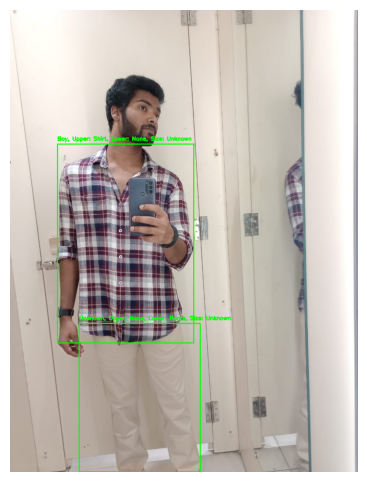

In [ ]:
results = process_single_image("/content/ad1.jpg")


In [ ]:
import cv2
from ultralytics import YOLO
import mediapipe as mp
from matplotlib import pyplot as plt
import os

# Load YOLO model (use your previous trained weights)
model_path = "/content/drive/MyDrive/YOLO_weights/best.pt"
model = YOLO(model_path)

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

# Clothing classes
upper_body_classes = ['Jacket', 'Shirt', 'Sweater', 'Top', 'Tshirt']
lower_body_classes = ['Pants', 'Shorts', 'Skirt']

girls_upper_classes = ['Top', 'Tshirt']  # female-oriented
boys_upper_classes = ['Shirt', 'Jacket', 'Sweater', 'Tshirt']  # male-oriented

def detect_person_type(upper_class):
    if upper_class in girls_upper_classes:
        return 'Girl'
    elif upper_class in boys_upper_classes:
        return 'Boy'
    else:
        return 'Unknown'

def estimate_size_person(cropped_img):
    if cropped_img is None or cropped_img.size == 0:
        return "Unknown"
    image_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    h, w, _ = cropped_img.shape
    results = pose.process(image_rgb)
    if not results.pose_landmarks:
        return "Unknown"
    lm = results.pose_landmarks.landmark
    try:
        head_y = lm[0].y
        left_ankle_y = lm[27].y
        right_ankle_y = lm[28].y
        bottom_y = max(left_ankle_y, right_ankle_y)
        left_shoulder_x = lm[11].x
        right_shoulder_x = lm[12].x

        pixel_height = (bottom_y - head_y) * h
        relative_height = pixel_height / h
        shoulder_width = abs(right_shoulder_x - left_shoulder_x) * w
        relative_width = shoulder_width / w
        score = 0.6 * relative_height + 0.4 * relative_width

        if score < 0.5:
            return 'Small'
        elif score < 0.7:
            return 'Medium'
        else:
            return 'Large'
    except:
        return "Unknown"

# -------------------------------
# Function to process a single image
# -------------------------------
def process_single_image(img_path, save_annotated=True, display=True, save_folder=None):
    """
    img_path: path to the new image
    Returns: list of dicts for each detected person/clothing
    """
    img = cv2.imread(img_path)
    if img is None:
        print("Image not found or cannot be read.")
        return

    results = model.predict(img, imgsz=640)
    annotated_img = img.copy()
    output_info = []

    for i, box in enumerate(results[0].boxes):
        cls_id = int(box.cls)
        class_name = model.names[cls_id].capitalize()
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(img.shape[1], x2), min(img.shape[0], y2)
        cropped_img = img[y1:y2, x1:x2]
        if cropped_img.size == 0:
            continue

        upper_class = class_name if class_name in upper_body_classes else None
        lower_class = class_name if class_name in lower_body_classes else None
        size_label = estimate_size_person(cropped_img)
        person_type = detect_person_type(upper_class)

        # Store all info in dictionary
        output_info.append({
            "upper_class": upper_class,
            "lower_class": lower_class,
            "size": size_label,
            "person_type": person_type,
            "box": (x1, y1, x2, y2),
            "cropped_img": cropped_img
        })

        # Draw annotated boxes
        label = f"{person_type}, {upper_class}/{lower_class}, Size: {size_label}"
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(annotated_img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

    # Save annotated image
    if save_annotated:
        if save_folder is None:
            save_folder = "/content/Annotated_Images"
        os.makedirs(save_folder, exist_ok=True)
        save_path = os.path.join(save_folder, f"annotated_{os.path.basename(img_path)}")
        cv2.imwrite(save_path, annotated_img)
        print(f"Annotated image saved to {save_path}")

    # Display annotated image
    if display:
        plt.figure(figsize=(10,6))
        plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    return output_info


In [ ]:
from google.colab import files
uploaded = files.upload()  # select multiple images if needed


Saving tro.jpg to tro (1).jpg


In [ ]:
from ultralytics import YOLO

# Load YOLO directly from Drive
model = YOLO("/content/drive/MyDrive/YOLO_weights/best.pt")


ModuleNotFoundError: No module named 'ultralytics'


0: 480x640 1 Shorts, 38.9ms
Speed: 3.0ms preprocess, 38.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)
Annotated image saved to /content/Annotated_Images/annotated_tro.jpg


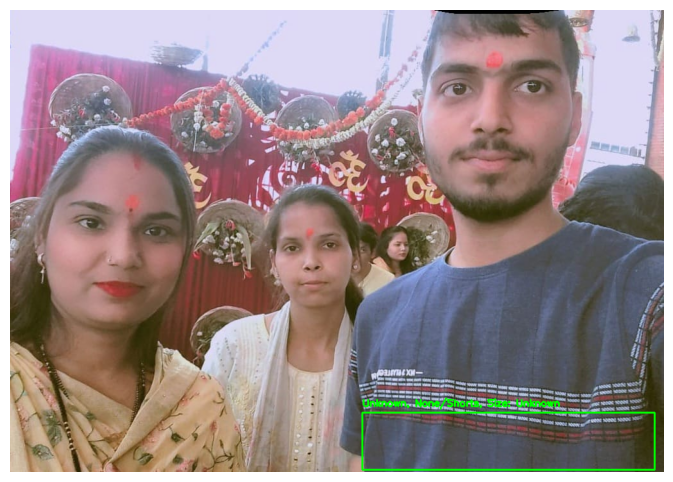

Person 1: Upper: None, Lower: Shorts, Size: Unknown, Type: Unknown


In [ ]:
# Pass a new image each time
results = process_single_image("/content/tro.jpg")

# Print all detected results
for i, person in enumerate(results):
    print(f"Person {i+1}: Upper: {person['upper_class']}, Lower: {person['lower_class']}, "
          f"Size: {person['size']}, Type: {person['person_type']}")


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/YOLO_weights/last (2).zip"
extract_path = "/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted successfully!")
!ls -lh /content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/


✅ Extracted successfully!
total 6.0M
-rw------- 1 root root  448 Oct 14 16:34  data.yaml
-rw------- 1 root root 6.0M Oct 15 04:55 'last (2).pt'
drwx------ 3 root root 4.0K Oct 15 04:51  last.pt
-rw------- 1 root root  185 Oct  2 16:49  README.dataset.txt
-rw------- 1 root root 1.2K Oct  2 16:49  README.roboflow.txt
drwx------ 2 root root 4.0K Oct  7 16:55  test
drwx------ 2 root root 4.0K Oct  7 16:55  train
drwx------ 2 root root 4.0K Oct  7 16:55  valid


In [ ]:
!ls -R "/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/last.pt"


/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/last.pt:


In [ ]:
import zipfile
zip_path = "/content/drive/MyDrive/YOLO_weights/last (2).zip"
extract_path = "/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted successfully!")
!ls -lh "/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/"


✅ Extracted successfully!
total 6.0M
-rw------- 1 root root  448 Oct 14 16:34  data.yaml
-rw------- 1 root root 6.0M Oct 15 04:55 'last (2).pt'
drwx------ 3 root root 4.0K Oct 15 04:51  last.pt
-rw------- 1 root root  185 Oct  2 16:49  README.dataset.txt
-rw------- 1 root root 1.2K Oct  2 16:49  README.roboflow.txt
drwx------ 2 root root 4.0K Oct  7 16:55  test
drwx------ 2 root root 4.0K Oct  7 16:55  train
drwx------ 2 root root 4.0K Oct  7 16:55  valid


In [ ]:
from ultralytics import YOLO

model_path = "/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/last (2).pt"
model = YOLO(model_path)
print("✅ Model loaded successfully!")


✅ Model loaded successfully!



image 1/1 /content/drive/MyDrive/Annotated_Images/annotated_ju.jpg: 640x320 (no detections), 11.3ms
Speed: 2.5ms preprocess, 11.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


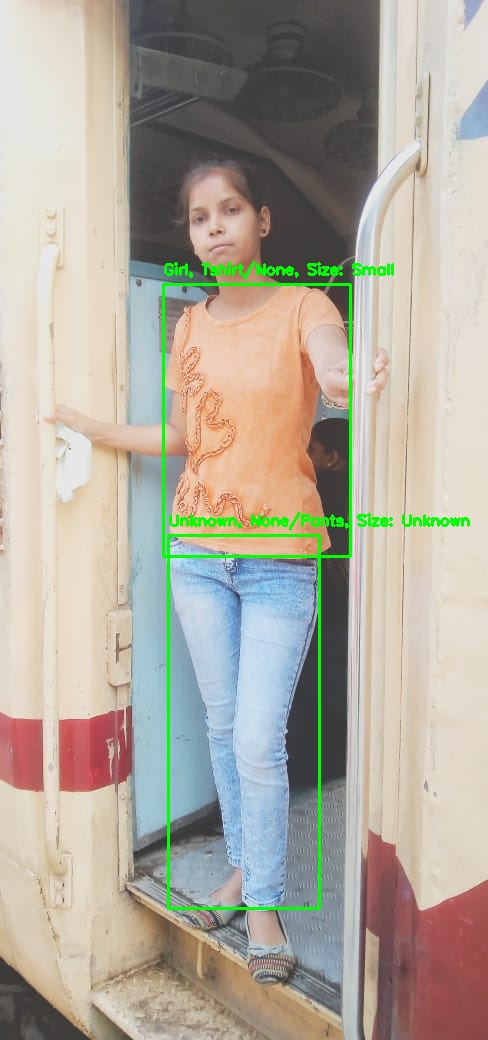

In [ ]:
results = model.predict(source="/content/drive/MyDrive/Annotated_Images/annotated_ju.jpg", imgsz=640)
results[0].show()


In [ ]:
import cv2
from ultralytics import YOLO
import mediapipe as mp
from matplotlib import pyplot as plt
import os

# Load YOLO model (use your previous trained weights)
model_path = "/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/last (2).pt"
model = YOLO(model_path)

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

# Clothing classes
upper_body_classes = ['Jacket', 'Shirt', 'Sweater', 'Top', 'Tshirt']
lower_body_classes = ['Pants', 'Shorts', 'Skirt']

girls_upper_classes = ['Top', 'Tshirt']  # female-oriented
boys_upper_classes = ['Shirt', 'Jacket', 'Sweater', 'Tshirt']  # male-oriented

def detect_person_type(upper_class):
    if upper_class in girls_upper_classes:
        return 'Girl'
    elif upper_class in boys_upper_classes:
        return 'Boy'
    else:
        return 'Unknown'

def estimate_size_person(cropped_img):
    if cropped_img is None or cropped_img.size == 0:
        return "Unknown"
    image_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    h, w, _ = cropped_img.shape
    results = pose.process(image_rgb)
    if not results.pose_landmarks:
        return "Unknown"
    lm = results.pose_landmarks.landmark
    try:
        head_y = lm[0].y
        left_ankle_y = lm[27].y
        right_ankle_y = lm[28].y
        bottom_y = max(left_ankle_y, right_ankle_y)
        left_shoulder_x = lm[11].x
        right_shoulder_x = lm[12].x

        pixel_height = (bottom_y - head_y) * h
        relative_height = pixel_height / h
        shoulder_width = abs(right_shoulder_x - left_shoulder_x) * w
        relative_width = shoulder_width / w
        score = 0.6 * relative_height + 0.4 * relative_width

        if score < 0.5:
            return 'Small'
        elif score < 0.7:
            return 'Medium'
        else:
            return 'Large'
    except:
        return "Unknown"

# -------------------------------
# Function to process a single image
# -------------------------------
def process_single_image(img_path, save_annotated=True, display=True, save_folder=None):
    """
    img_path: path to the new image
    Returns: list of dicts for each detected person/clothing
    """
    img = cv2.imread(img_path)
    if img is None:
        print("Image not found or cannot be read.")
        return

    results = model.predict(img, imgsz=640)
    annotated_img = img.copy()
    output_info = []

    for i, box in enumerate(results[0].boxes):
        cls_id = int(box.cls)
        class_name = model.names[cls_id].capitalize()
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(img.shape[1], x2), min(img.shape[0], y2)
        cropped_img = img[y1:y2, x1:x2]
        if cropped_img.size == 0:
            continue

        upper_class = class_name if class_name in upper_body_classes else None
        lower_class = class_name if class_name in lower_body_classes else None
        size_label = estimate_size_person(cropped_img)
        person_type = detect_person_type(upper_class)

        # Store all info in dictionary
        output_info.append({
            "upper_class": upper_class,
            "lower_class": lower_class,
            "size": size_label,
            "person_type": person_type,
            "box": (x1, y1, x2, y2),
            "cropped_img": cropped_img
        })

        # Draw annotated boxes
        label = f"{person_type}, {upper_class}/{lower_class}, Size: {size_label}"
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(annotated_img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

    # Save annotated image
    if save_annotated:
        if save_folder is None:
            save_folder = "/content/Annotated_Images"
        os.makedirs(save_folder, exist_ok=True)
        save_path = os.path.join(save_folder, f"annotated_{os.path.basename(img_path)}")
        cv2.imwrite(save_path, annotated_img)
        print(f"Annotated image saved to {save_path}")

    # Display annotated image
    if display:
        plt.figure(figsize=(10,6))
        plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    return output_info


In [ ]:
from google.colab import files
uploaded = files.upload()  # select multiple images if needed


Saving akash.jpg to akash.jpg



0: 640x640 1 Pants, 1 Shirt, 9.9ms
Speed: 3.5ms preprocess, 9.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)
Annotated image saved to /content/Annotated_Images/annotated_akash.jpg


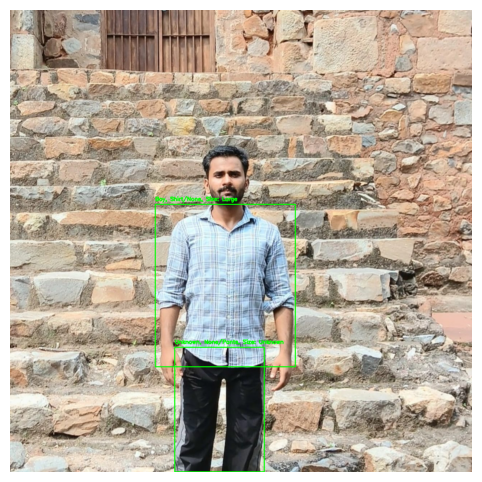

Person 1: Upper: Shirt, Lower: None, Size: Large, Type: Boy
Person 2: Upper: None, Lower: Pants, Size: Unknown, Type: Unknown


In [ ]:
# Pass a new image each time
results = process_single_image("/content/akash.jpg")

# Print all detected results
for i, person in enumerate(results):
    print(f"Person {i+1}: Upper: {person['upper_class']}, Lower: {person['lower_class']}, "
          f"Size: {person['size']}, Type: {person['person_type']}")


In [ ]:
# ------------------------------
# YOLOv8 Resume Training Block
# ------------------------------

from ultralytics import YOLO
import os

# 1️⃣ Paths
# Path to the last trained model (replace with your last.pt or last (2).pt)
last_model_path = "/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/last (2).pt"

# Path to your dataset YAML
data_yaml = "/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/data.yaml"

# Optional: Backup folder in Drive
backup_folder = "/content/drive/MyDrive/YOLO_weights_backups"
os.makedirs(backup_folder, exist_ok=True)

# Backup last.pt before resuming
backup_path = os.path.join(backup_folder, "last_backup.pt")
!cp "{last_model_path}" "{backup_path}"
print(f"✅ Backup created at {backup_path}")

# 2️⃣ Load the last trained model
model = YOLO(last_model_path)
print("✅ Loaded last trained model successfully!")

# 3️⃣ Resume Training
# Total epochs you want (e.g., continue from 35 to 50)
total_epochs = 50

model.train(
    data=data_yaml,   # dataset YAML
    epochs=total_epochs,
    resume=True,      # resume from last.pt
    imgsz=640,        # optional: input image size
    batch=8,         # optional: batch size
    lr0=0.001,        # optional: learning rate
    patience=10       # optional: early stopping patience
)

print("✅ Training resumed successfully!")


✅ Backup created at /content/drive/MyDrive/YOLO_weights_backups/last_backup.pt
✅ Loaded last trained model successfully!
Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=35, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/image_1/clot

AssertionError: /content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/last (2).pt training to 35 epochs is finished, nothing to resume.
Start a new training without resuming, i.e. 'yolo train model=/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/last (2).pt'

In [ ]:
# ------------------------------
# YOLOv8 Continue Training From Epoch 36
# ------------------------------

from ultralytics import YOLO
import os

# 1️⃣ Paths
# Path to your last trained weights
last_weights = "/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/last (2).pt"

# Path to dataset YAML
data_yaml = "/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/data.yaml"

# Backup folder
backup_folder = "/content/drive/MyDrive/YOLO_weights_backups"
os.makedirs(backup_folder, exist_ok=True)

# Backup the last weights first
backup_path = os.path.join(backup_folder, "last_35_epochs_backup.pt")
!cp "{last_weights}" "{backup_path}"
print(f"✅ Backup created at {backup_path}")

# 2️⃣ Load YOLO model with last weights
# We'll manually adjust start_epoch for proper counting
model = YOLO(last_weights)
print("✅ Loaded last trained weights successfully!")

# 3️⃣ Define total additional epochs
additional_epochs = 20
# Start epoch manually = 36
start_epoch = 36
total_epochs = start_epoch + additional_epochs - 1  # total epoch count for display

# 4️⃣ Continue training
# YOLO doesn’t natively support displaying start_epoch > 0 when resume=False
# So we will create a new run folder to separate from previous run
run_name = f"clothing_custom_continued_from_{start_epoch}"

model.train(
    data=data_yaml,
    epochs=additional_epochs,       # epochs in this run (counts from 0 internally)
    model=last_weights,             # starting weights
    resume=False,                   # treat as a new run but weights from last.pt
    imgsz=640,
    batch=8,
    lr0=0.001,
    patience=10,
    name=run_name                   # new run folder
)

print(f"✅ Training continued from epoch {start_epoch} for {additional_epochs} more epochs!")
print(f"📁 New run saved at: /content/runs/detect/{run_name}/weights/")


✅ Backup created at /content/drive/MyDrive/YOLO_weights_backups/last_35_epochs_backup.pt
✅ Loaded last trained weights successfully!
Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive

In [ ]:
import os
import shutil
from glob import glob

# ------------------------------
# 1️⃣ Base paths
# ------------------------------
drive_base = "/content/drive/MyDrive"  # Change for Windows if needed
backup_base = os.path.join(drive_base, "YOLO_Training")
os.makedirs(backup_base, exist_ok=True)

# Subfolders
folders = ["weights", "runs", "Annotated_Images", "config", "scripts"]
for f in folders:
    os.makedirs(os.path.join(backup_base, f), exist_ok=True)

# ------------------------------
# 2️⃣ Detect and backup run folders
# ------------------------------
runs_root = "/content/runs/detect"  # all YOLO runs are here
run_folders = [f for f in os.listdir(runs_root) if os.path.isdir(os.path.join(runs_root, f))]

for r in run_folders:
    src = os.path.join(runs_root, r)
    dest = os.path.join(backup_base, "runs", r)
    shutil.copytree(src, dest, dirs_exist_ok=True)
    print(f"✅ Copied run folder: {r}")

# ------------------------------
# 3️⃣ Backup latest weights from each run
# ------------------------------
for r in run_folders:
    weights_folder = os.path.join(runs_root, r, "weights")
    if os.path.exists(weights_folder):
        pt_files = glob(os.path.join(weights_folder, "*.pt"))
        for pt in pt_files:
            shutil.copy(pt, os.path.join(backup_base, "weights"))
            print(f"✅ Copied {os.path.basename(pt)} from {r} to weights/")
    else:
        print(f"⚠️ No weights found in {r}")

# Optionally copy pretrained weights
pretrained_path = os.path.expanduser("~/.cache/ultralytics/yolo/weights/yolov8n.pt")
if os.path.exists(pretrained_path):
    shutil.copy(pretrained_path, os.path.join(backup_base, "weights"))
    print("✅ Copied pretrained yolov8n.pt")
else:
    print("⚠️ Pretrained yolov8n.pt not found")

# ------------------------------
# 4️⃣ Backup Annotated Images
# ------------------------------
annotated_images = "/content/Annotated_Images"
if os.path.exists(annotated_images):
    dest = os.path.join(backup_base, "Annotated_Images")
    shutil.copytree(annotated_images, dest, dirs_exist_ok=True)
    print("✅ Copied Annotated_Images folder")
else:
    print("⚠️ Annotated_Images folder not found")

# ------------------------------
# 5️⃣ Backup config files
# ------------------------------
configs = glob("/content/**/*.yaml", recursive=True)  # detect all YAMLs in content
for c in configs:
    shutil.copy(c, os.path.join(backup_base, "config"))
    print(f"✅ Copied {os.path.basename(c)} to config/")

# ------------------------------
# 6️⃣ Backup scripts
# ------------------------------
scripts = glob("/content/*.py")  # all Python scripts in content
for s in scripts:
    shutil.copy(s, os.path.join(backup_base, "scripts"))
    print(f"✅ Copied {os.path.basename(s)} to scripts/")

print("\n🎉 Backup complete! All YOLO files saved to:")
print(backup_base)


✅ Copied run folder: clothing_custom
✅ Copied run folder: clothing_custom_continued_from_36
✅ Copied best.pt from clothing_custom_continued_from_36 to weights/
✅ Copied last.pt from clothing_custom_continued_from_36 to weights/
⚠️ Pretrained yolov8n.pt not found
✅ Copied Annotated_Images folder
✅ Copied data.yaml to config/
✅ Copied args.yaml to config/
✅ Copied args.yaml to config/
✅ Copied args.yaml to config/
✅ Copied args.yaml to config/

🎉 Backup complete! All YOLO files saved to:
/content/drive/MyDrive/YOLO_Training


In [ ]:
from google.colab import files
uploaded = files.upload()  # select multiple images if needed


Saving akash.jpg to akash.jpg


In [ ]:
!pip install ultralytics==8.2.0 mediapipe opencv-python matplotlib


In [ ]:
from ultralytics import YOLO
import mediapipe as mp
import cv2


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [ ]:
!pip install -U ultralytics


In [ ]:
import os
import shutil
from glob import glob

# ------------------------------
# 1️⃣ Base paths
# ------------------------------
drive_base = "/content/drive/MyDrive"  # Change for Windows if needed
backup_base = os.path.join(drive_base, "YOLO_Training")
os.makedirs(backup_base, exist_ok=True)

# Subfolders
folders = ["weights", "runs", "Annotated_Images", "config", "scripts"]
for f in folders:
    os.makedirs(os.path.join(backup_base, f), exist_ok=True)

# ------------------------------
# 2️⃣ Detect and backup run folders
# ------------------------------
runs_root = "/content/runs/detect"  # all YOLO runs are here
run_folders = [f for f in os.listdir(runs_root) if os.path.isdir(os.path.join(runs_root, f))]

for r in run_folders:
    src = os.path.join(runs_root, r)
    dest = os.path.join(backup_base, "runs", r)
    shutil.copytree(src, dest, dirs_exist_ok=True)
    print(f"✅ Copied run folder: {r}")

# ------------------------------
# 3️⃣ Backup latest weights from each run
# ------------------------------
for r in run_folders:
    weights_folder = os.path.join(runs_root, r, "weights")
    if os.path.exists(weights_folder):
        pt_files = glob(os.path.join(weights_folder, "*.pt"))
        for pt in pt_files:
            shutil.copy(pt, os.path.join(backup_base, "weights"))
            print(f"✅ Copied {os.path.basename(pt)} from {r} to weights/")
    else:
        print(f"⚠️ No weights found in {r}")

# Optionally copy pretrained weights
pretrained_path = os.path.expanduser("~/.cache/ultralytics/yolo/weights/yolov8n.pt")
if os.path.exists(pretrained_path):
    shutil.copy(pretrained_path, os.path.join(backup_base, "weights"))
    print("✅ Copied pretrained yolov8n.pt")
else:
    print("⚠️ Pretrained yolov8n.pt not found")

# ------------------------------
# 4️⃣ Backup Annotated Images
# ------------------------------
annotated_images = "/content/Annotated_Images"
if os.path.exists(annotated_images):
    dest = os.path.join(backup_base, "Annotated_Images")
    shutil.copytree(annotated_images, dest, dirs_exist_ok=True)
    print("✅ Copied Annotated_Images folder")
else:
    print("⚠️ Annotated_Images folder not found")

# ------------------------------
# 5️⃣ Backup config files
# ------------------------------
configs = glob("/content/**/*.yaml", recursive=True)  # detect all YAMLs in content
for c in configs:
    shutil.copy(c, os.path.join(backup_base, "config"))
    print(f"✅ Copied {os.path.basename(c)} to config/")

# ------------------------------
# 6️⃣ Backup scripts
# ------------------------------
scripts = glob("/content/*.py")  # all Python scripts in content
for s in scripts:
    shutil.copy(s, os.path.join(backup_base, "scripts"))
    print(f"✅ Copied {os.path.basename(s)} to scripts/")

print("\n🎉 Backup complete! All YOLO files saved to:")
print(backup_base)


FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/detect'

In [ ]:
import os
import shutil
from glob import glob

# ------------------------------
# 1️⃣ Base paths
# ------------------------------
drive_base = "/content/drive/MyDrive"  # Change if needed
backup_base = os.path.join(drive_base, "YOLO_Training")
os.makedirs(backup_base, exist_ok=True)

# Subfolders
folders = ["weights", "runs", "Annotated_Images", "config", "scripts"]
for f in folders:
    os.makedirs(os.path.join(backup_base, f), exist_ok=True)

# ------------------------------
# 2️⃣ Detect which YOLO run folder exists
# ------------------------------
runs_root_detect = "/content/runs/detect"
runs_root_train = "/content/runs/train"

if os.path.exists(runs_root_detect):
    runs_root = runs_root_detect
    print("📂 Found YOLO detection runs folder.")
elif os.path.exists(runs_root_train):
    runs_root = runs_root_train
    print("📂 Found YOLO training runs folder.")
else:
    runs_root = None
    print("⚠️ No YOLO run folder found (neither detect nor train). Skipping run backup.")

# ------------------------------
# 3️⃣ Backup run folders (if found)
# ------------------------------
if runs_root:
    run_folders = [f for f in os.listdir(runs_root) if os.path.isdir(os.path.join(runs_root, f))]
    for r in run_folders:
        src = os.path.join(runs_root, r)
        dest = os.path.join(backup_base, "runs", r)
        shutil.copytree(src, dest, dirs_exist_ok=True)
        print(f"✅ Copied run folder: {r}")

    # ------------------------------
    # 4️⃣ Backup latest weights from each run
    # ------------------------------
    for r in run_folders:
        weights_folder = os.path.join(runs_root, r, "weights")
        if os.path.exists(weights_folder):
            pt_files = glob(os.path.join(weights_folder, "*.pt"))
            for pt in pt_files:
                shutil.copy(pt, os.path.join(backup_base, "weights"))
                print(f"✅ Copied {os.path.basename(pt)} from {r} to weights/")
        else:
            print(f"⚠️ No weights found in {r}")
else:
    print("⚠️ Skipped run and weights backup because no run folder exists.")

# ------------------------------
# 5️⃣ Backup pretrained YOLO weights
# ------------------------------
pretrained_path = os.path.expanduser("~/.cache/ultralytics/yolo/weights/yolov8n.pt")
if os.path.exists(pretrained_path):
    shutil.copy(pretrained_path, os.path.join(backup_base, "weights"))
    print("✅ Copied pretrained yolov8n.pt")
else:
    print("⚠️ Pretrained yolov8n.pt not found")

# ------------------------------
# 6️⃣ Backup Annotated Images
# ------------------------------
annotated_images = "/content/Annotated_Images"
if os.path.exists(annotated_images):
    dest = os.path.join(backup_base, "Annotated_Images")
    shutil.copytree(annotated_images, dest, dirs_exist_ok=True)
    print("✅ Copied Annotated_Images folder")
else:
    print("⚠️ Annotated_Images folder not found")

# ------------------------------
# 7️⃣ Backup config files
# ------------------------------
configs = glob("/content/**/*.yaml", recursive=True)
for c in configs:
    shutil.copy(c, os.path.join(backup_base, "config"))
    print(f"✅ Copied {os.path.basename(c)} to config/")

# ------------------------------
# 8️⃣ Backup scripts
# ------------------------------
scripts = glob("/content/*.py")
for s in scripts:
    shutil.copy(s, os.path.join(backup_base, "scripts"))
    print(f"✅ Copied {os.path.basename(s)} to scripts/")

print("\n🎉 Backup complete! All YOLO files saved to:")
print(backup_base)


⚠️ No YOLO run folder found (neither detect nor train). Skipping run backup.
⚠️ Skipped run and weights backup because no run folder exists.
⚠️ Pretrained yolov8n.pt not found
⚠️ Annotated_Images folder not found
✅ Copied data.yaml to config/
✅ Copied args.yaml to config/
✅ Copied args.yaml to config/


SameFileError: '/content/drive/MyDrive/YOLO_Training/config/data.yaml' and '/content/drive/MyDrive/YOLO_Training/config/data.yaml' are the same file

In [ ]:
# ------------------------------
# 7️⃣ Backup config files (fixed to skip same-path files)
# ------------------------------
configs = glob("/content/**/*.yaml", recursive=True)
config_dest = os.path.join(backup_base, "config")

for c in configs:
    dest_file = os.path.join(config_dest, os.path.basename(c))
    # Skip if source and destination are same
    if os.path.abspath(c) == os.path.abspath(dest_file):
        continue
    try:
        shutil.copy(c, config_dest)
        print(f"✅ Copied {os.path.basename(c)} to config/")
    except shutil.SameFileError:
        print(f"⚠️ Skipped {os.path.basename(c)} (same file)")


✅ Copied data.yaml to config/
✅ Copied args.yaml to config/
✅ Copied args.yaml to config/


In [ ]:
import os
import shutil
from glob import glob
from datetime import datetime

# ------------------------------
# 1️⃣ Create timestamped folder
# ------------------------------
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
drive_base = "/content/drive/MyDrive"
backup_base = os.path.join(drive_base, f"YOLO_Training_Backup_{timestamp}")
os.makedirs(backup_base, exist_ok=True)

# Subfolders to organize backups
folders = ["weights", "runs", "Annotated_Images", "config", "scripts"]
for f in folders:
    os.makedirs(os.path.join(backup_base, f), exist_ok=True)

print(f"🕒 Backup folder created: {backup_base}")

# ------------------------------
# 2️⃣ Detect which YOLO run folder exists
# ------------------------------
runs_root_detect = "/content/runs/detect"
runs_root_train = "/content/runs/train"

if os.path.exists(runs_root_detect):
    runs_root = runs_root_detect
    print("📂 Found YOLO detection runs folder.")
elif os.path.exists(runs_root_train):
    runs_root = runs_root_train
    print("📂 Found YOLO training runs folder.")
else:
    runs_root = None
    print("⚠️ No YOLO run folder found (neither detect nor train). Skipping run backup.")

# ------------------------------
# 3️⃣ Backup run folders and weights
# ------------------------------
if runs_root:
    run_folders = [f for f in os.listdir(runs_root) if os.path.isdir(os.path.join(runs_root, f))]
    for r in run_folders:
        src = os.path.join(runs_root, r)
        dest = os.path.join(backup_base, "runs", r)
        shutil.copytree(src, dest, dirs_exist_ok=True)
        print(f"✅ Copied run folder: {r}")

    # Backup .pt weights from each run
    for r in run_folders:
        weights_folder = os.path.join(runs_root, r, "weights")
        if os.path.exists(weights_folder):
            pt_files = glob(os.path.join(weights_folder, "*.pt"))
            for pt in pt_files:
                shutil.copy(pt, os.path.join(backup_base, "weights"))
                print(f"✅ Copied {os.path.basename(pt)} from {r} to weights/")
        else:
            print(f"⚠️ No weights found in {r}")
else:
    print("⚠️ Skipped run and weights backup because no run folder exists.")

# ------------------------------
# 4️⃣ Backup pretrained YOLO weights (if exist)
# ------------------------------
pretrained_path = os.path.expanduser("~/.cache/ultralytics/yolo/weights/yolov8n.pt")
if os.path.exists(pretrained_path):
    shutil.copy(pretrained_path, os.path.join(backup_base, "weights"))
    print("✅ Copied pretrained yolov8n.pt")
else:
    print("⚠️ Pretrained yolov8n.pt not found")

# ------------------------------
# 5️⃣ Backup Annotated Images
# ------------------------------
annotated_images = "/content/Annotated_Images"
if os.path.exists(annotated_images):
    dest = os.path.join(backup_base, "Annotated_Images")
    shutil.copytree(annotated_images, dest, dirs_exist_ok=True)
    print("✅ Copied Annotated_Images folder")
else:
    print("⚠️ Annotated_Images folder not found")

# ------------------------------
# 6️⃣ Backup config files (safe from duplicates)
# ------------------------------
configs = [
    c for c in glob("/content/**/*.yaml", recursive=True)
    if "YOLO_Training_Backup" not in c  # exclude backup folder
]
config_dest = os.path.join(backup_base, "config")

for c in configs:
    dest_file = os.path.join(config_dest, os.path.basename(c))
    if os.path.abspath(c) == os.path.abspath(dest_file):
        continue
    try:
        shutil.copy(c, config_dest)
        print(f"✅ Copied {os.path.basename(c)} to config/")
    except shutil.SameFileError:
        print(f"⚠️ Skipped {os.path.basename(c)} (same file)")

# ------------------------------
# 7️⃣ Backup scripts
# ------------------------------
scripts = glob("/content/*.py")
for s in scripts:
    shutil.copy(s, os.path.join(backup_base, "scripts"))
    print(f"✅ Copied {os.path.basename(s)} to scripts/")

# ------------------------------
# 8️⃣ Done!
# ------------------------------
print("\n🎉 Backup complete! All YOLO files saved to:")
print(backup_base)


🕒 Backup folder created: /content/drive/MyDrive/YOLO_Training_Backup_2025-11-13_17-46-52
⚠️ No YOLO run folder found (neither detect nor train). Skipping run backup.
⚠️ Skipped run and weights backup because no run folder exists.
⚠️ Pretrained yolov8n.pt not found
⚠️ Annotated_Images folder not found
✅ Copied data.yaml to config/
✅ Copied args.yaml to config/
✅ Copied args.yaml to config/
✅ Copied data.yaml to config/
✅ Copied args.yaml to config/

🎉 Backup complete! All YOLO files saved to:
/content/drive/MyDrive/YOLO_Training_Backup_2025-11-13_17-46-52


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/YOLO_weights/last (2).zip"
extract_path = "/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted successfully!")
!ls -lh /content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/


✅ Extracted successfully!
total 6.0M
-rw------- 1 root root  448 Oct 14 16:34  data.yaml
-rw------- 1 root root 6.0M Nov 13 18:06 'last (2).pt'
drwx------ 3 root root 4.0K Oct 15 04:42  last.pt
-rw------- 1 root root  185 Oct  2 16:49  README.dataset.txt
-rw------- 1 root root 1.2K Oct  2 16:49  README.roboflow.txt
drwx------ 4 root root 4.0K Oct  7 16:55  test
drwx------ 4 root root 4.0K Oct  7 16:55  train
drwx------ 4 root root 4.0K Oct  7 16:55  valid


In [ ]:
!ls -R "/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/last.pt"


/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/last.pt:


In [ ]:
import zipfile
zip_path = "/content/drive/MyDrive/YOLO_weights/last (2).zip"
extract_path = "/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted successfully!")
!ls -lh "/content/drive/MyDrive/image_1/clothes-segmentation-final.v2i.yolov8/"


✅ Extracted successfully!
total 6.0M
-rw------- 1 root root  448 Oct 14 16:34  data.yaml
-rw------- 1 root root 6.0M Nov 13 18:08 'last (2).pt'
drwx------ 3 root root 4.0K Oct 15 04:42  last.pt
-rw------- 1 root root  185 Oct  2 16:49  README.dataset.txt
-rw------- 1 root root 1.2K Oct  2 16:49  README.roboflow.txt
drwx------ 4 root root 4.0K Oct  7 16:55  test
drwx------ 4 root root 4.0K Oct  7 16:55  train
drwx------ 4 root root 4.0K Oct  7 16:55  valid


In [ ]:
from ultralytics import YOLO

model_path = "/content/drive/MyDrive/YOLO_weights/last (2).zip"
model = YOLO(model_path)
print("✅ Model loaded successfully!")


WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
✅ Model loaded successfully!


In [ ]:
# Hi! Step 1: Install dependencies and import libraries
!pip install ultralytics opencv-python matplotlib mediapipe

# Import libraries
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt
from ultralytics import YOLO


INFO: pip is looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 27.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have proto

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Saving ad1.jpg to ad1.jpg

image 1/1 /content/ad1.jpg: 640x512 1 Pants, 1 Shirt, 65.4ms
Speed: 13.2ms preprocess, 65.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 512)
Person 1 in ad1.jpg:
  Size: Unknown
  Upper Body: Shirt
  Lower Body: None
  Person Type: Boy
------
Person 2 in ad1.jpg:
  Size: Unknown
  Upper Body: None
  Lower Body: Pants
  Person Type: Unknown
------
Saved annotated image to /content/drive/MyDrive/Annotated_Images/annotated_ad1.jpg


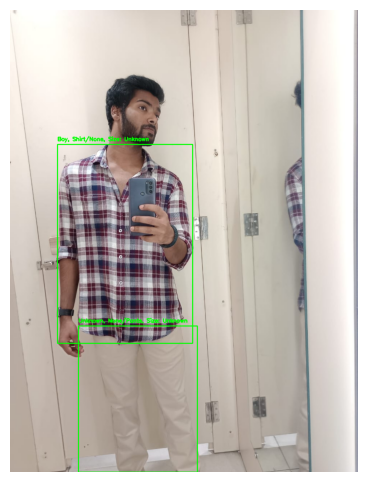

In [ ]:
# -------------------------------
# Step 1: Upload Images
# -------------------------------
from google.colab import files
uploaded = files.upload()  # select multiple images if needed

# -------------------------------
# Step 2: Load YOLOv8 Model
# -------------------------------
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import mediapipe as mp
import os

# Select the model you want to use
# Options: best.pt, last.pt, yolov8n.pt
model_path = "/content/drive/MyDrive/YOLO_Training/weights/last.pt"
model = YOLO(model_path)

# Initialize MediaPipe Pose globally
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

# -------------------------------
# Step 3: Define Classes (No accessories)
# -------------------------------
upper_body_classes = ['Jacket', 'Shirt', 'Sweater', 'Top', 'Tshirt']
lower_body_classes = ['Pants', 'Shorts', 'Skirt']

# Gender detection based on upper body
girls_upper_classes = ['Top', 'Tshirt']  # female-oriented
boys_upper_classes = ['Shirt', 'Jacket', 'Sweater', 'Tshirt']  # male-oriented

def detect_person_type(upper_class):
    if upper_class in girls_upper_classes:
        return 'Girl'
    elif upper_class in boys_upper_classes:
        return 'Boy'
    else:
        return 'Unknown'

# -------------------------------
# Step 4: Size Estimation Function
# -------------------------------
def estimate_size_person(cropped_img):
    if cropped_img is None or cropped_img.size == 0:
        return "Unknown"

    image_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    h, w, _ = cropped_img.shape
    results = pose.process(image_rgb)

    if not results.pose_landmarks:
        return "Unknown"

    lm = results.pose_landmarks.landmark
    try:
        head_y = lm[0].y
        left_ankle_y = lm[27].y
        right_ankle_y = lm[28].y
        bottom_y = max(left_ankle_y, right_ankle_y)
        left_shoulder_x = lm[11].x
        right_shoulder_x = lm[12].x

        pixel_height = (bottom_y - head_y) * h
        relative_height = pixel_height / h
        shoulder_width = abs(right_shoulder_x - left_shoulder_x) * w
        relative_width = shoulder_width / w
        score = 0.6 * relative_height + 0.4 * relative_width

        if score < 0.5:
            return 'Small'
        elif score < 0.7:
            return 'Medium'
        else:
            return 'Large'
    except:
        return "Unknown"

# -------------------------------
# Step 5: Detect and Annotate Images
# -------------------------------
# Path to save annotated images
drive_save_path = "/content/drive/MyDrive/Annotated_Images"
os.makedirs(drive_save_path, exist_ok=True)

for image_path in uploaded.keys():
    img = cv2.imread(image_path)
    results = model.predict(image_path, imgsz=640)
    annotated_img = img.copy()

    for i, box in enumerate(results[0].boxes):
        cls_id = int(box.cls)
        class_name = model.names[cls_id].capitalize()
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(img.shape[1], x2), min(img.shape[0], y2)
        cropped_person = img[y1:y2, x1:x2]
        if cropped_person.size == 0:
            continue

        # Determine upper/lower clothing
        upper_class = class_name if class_name in upper_body_classes else None
        lower_class = class_name if class_name in lower_body_classes else None

        # Size and person type
        size_label = estimate_size_person(cropped_person)
        person_type = detect_person_type(upper_class)

        # Draw boxes and label
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0,255,0), 2)
        label = f"{person_type}, {upper_class}/{lower_class}, Size: {size_label}"
        cv2.putText(annotated_img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

        # Print details
        print(f"Person {i+1} in {image_path}:")
        print(f"  Size: {size_label}")
        print(f"  Upper Body: {upper_class}")
        print(f"  Lower Body: {lower_class}")
        print(f"  Person Type: {person_type}")
        print("------")

    # Save annotated image to Drive
    save_file = os.path.join(drive_save_path, f"annotated_{image_path}")
    cv2.imwrite(save_file, annotated_img)
    print(f"Saved annotated image to {save_file}")

    # Display annotated image
    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [ ]:
import cv2
from ultralytics import YOLO
import mediapipe as mp
from matplotlib import pyplot as plt
import os

# Load YOLO model (use your previous trained weights)
model_path = "/content/drive/MyDrive/YOLO_Training/weights/last.pt"
model = YOLO(model_path)

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

# Clothing classes
upper_body_classes = ['Jacket', 'Shirt', 'Sweater', 'Top', 'Tshirt']
lower_body_classes = ['Pants', 'Shorts', 'Skirt']

girls_upper_classes = ['Top', 'Tshirt']  # female-oriented
boys_upper_classes = ['Shirt', 'Jacket', 'Sweater', 'Tshirt']  # male-oriented

def detect_person_type(upper_class):
    if upper_class in girls_upper_classes:
        return 'Girl'
    elif upper_class in boys_upper_classes:
        return 'Boy'
    else:
        return 'Unknown'

def estimate_size_person(cropped_img):
    if cropped_img is None or cropped_img.size == 0:
        return "Unknown"
    image_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    h, w, _ = cropped_img.shape
    results = pose.process(image_rgb)
    if not results.pose_landmarks:
        return "Unknown"
    lm = results.pose_landmarks.landmark
    try:
        head_y = lm[0].y
        left_ankle_y = lm[27].y
        right_ankle_y = lm[28].y
        bottom_y = max(left_ankle_y, right_ankle_y)
        left_shoulder_x = lm[11].x
        right_shoulder_x = lm[12].x

        pixel_height = (bottom_y - head_y) * h
        relative_height = pixel_height / h
        shoulder_width = abs(right_shoulder_x - left_shoulder_x) * w
        relative_width = shoulder_width / w
        score = 0.6 * relative_height + 0.4 * relative_width

        if score < 0.5:
            return 'Small'
        elif score < 0.7:
            return 'Medium'
        else:
            return 'Large'
    except:
        return "Unknown"

# -------------------------------
# Function to process a single image
# -------------------------------
def process_single_image(img_path, save_annotated=True, display=True, save_folder=None):
    """
    img_path: path to the new image
    Returns: list of dicts for each detected person/clothing
    """
    img = cv2.imread(img_path)
    if img is None:
        print("Image not found or cannot be read.")
        return

    results = model.predict(img, imgsz=640)
    annotated_img = img.copy()
    output_info = []

    for i, box in enumerate(results[0].boxes):
        cls_id = int(box.cls)
        class_name = model.names[cls_id].capitalize()
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(img.shape[1], x2), min(img.shape[0], y2)
        cropped_img = img[y1:y2, x1:x2]
        if cropped_img.size == 0:
            continue

        upper_class = class_name if class_name in upper_body_classes else None
        lower_class = class_name if class_name in lower_body_classes else None
        size_label = estimate_size_person(cropped_img)
        person_type = detect_person_type(upper_class)

        # Store all info in dictionary
        output_info.append({
            "upper_class": upper_class,
            "lower_class": lower_class,
            "size": size_label,
            "person_type": person_type,
            "box": (x1, y1, x2, y2),
            "cropped_img": cropped_img
        })

        # Draw annotated boxes
        label = f"{person_type}, {upper_class}/{lower_class}, Size: {size_label}"
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(annotated_img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

    # Save annotated image
    if save_annotated:
        if save_folder is None:
            save_folder = "/content/Annotated_Images"
        os.makedirs(save_folder, exist_ok=True)
        save_path = os.path.join(save_folder, f"annotated_{os.path.basename(img_path)}")
        cv2.imwrite(save_path, annotated_img)
        print(f"Annotated image saved to {save_path}")

    # Display annotated image
    if display:
        plt.figure(figsize=(10,6))
        plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    return output_info


In [ ]:
from google.colab import files
uploaded = files.upload()  # select multiple images if needed


Saving ashwa.jpg to ashwa (1).jpg



0: 640x544 2 Jackets, 1 Pants, 43.8ms
Speed: 3.5ms preprocess, 43.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)
Annotated image saved to /content/Annotated_Images/annotated_ashwa.jpg


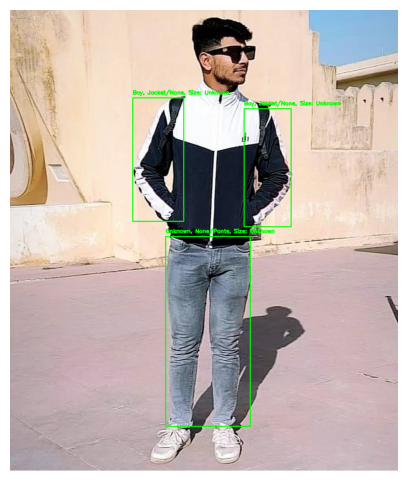

Person 1: Upper: None, Lower: Pants, Size: Unknown, Type: Unknown
Person 2: Upper: Jacket, Lower: None, Size: Unknown, Type: Boy
Person 3: Upper: Jacket, Lower: None, Size: Unknown, Type: Boy


In [ ]:
# Pass a new image each time
results = process_single_image("/content/ashwa.jpg")

# Print all detected results
for i, person in enumerate(results):
    print(f"Person {i+1}: Upper: {person['upper_class']}, Lower: {person['lower_class']}, "
          f"Size: {person['size']}, Type: {person['person_type']}")
